In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = "retina"
sns.set()
plt.rcParams["figure.figsize"] = (9,6)
plt.rcParams.update({"axes.labelpad":10})
sns.set_style("darkgrid")
import string
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
print("Libraries imported")

Libraries imported


# Data preprocessing 

In [2]:
test = pd.read_csv(r"C:\Users\HP\Modelling\Documents\Car price prediction\Test.csv")
train = pd.read_csv(r"C:\Users\HP\Modelling\Documents\Car price prediction\Train.csv")
sample_submission = pd.read_csv(r"C:\Users\HP\Modelling\Documents\Car price prediction\SampleSubmission.csv")
variable_definition = pd.read_csv(r"C:\Users\HP\Modelling\Documents\Car price prediction\VariableDefinitions.csv")

In [3]:
sample_submission

,VehicleID,Amount (Million Naira)
0,VHL18518,1.0
1,VHL17149,1.0
2,VHL10927,1.0
3,VHL12909,1.0
4,VHL12348,1.0
...,...,...
2056,VHL17903,1.0
2057,VHL14018,1.0
2058,VHL17473,1.0
2059,VHL11480,1.0


In [4]:
test.head()

,VehicleID,Location,Maker,Model,Year,Colour,Type,Distance
0,VHL18518,Abuja,BMW,323i,"2,008",White,Foreign Used,30524.0
1,VHL17149,Lagos,Toyota,Camry,"2,013",White,Foreign Used,NaN
2,VHL10927,Lagos,Toyota,Highlander Limited V6,"2,005",Gold,Foreign Used,NaN
3,VHL12909,Lagos,Toyota,Camry,"2,011",Gray,Foreign Used,166839.0
4,VHL12348,Lagos,Lexus,ES 350 FWD,"2,013",Red,Foreign Used,88862.0


In [5]:
train.head()

,VehicleID,Location,Maker,Model,Year,Colour,Amount (Million Naira),Type,Distance
0,VHL12546,Abuja,Honda,Accord Coupe EX V-6,"2,011",Silver,2.2,Nigerian Used,NaN
1,VHL18827,Ibadan,Hyundai,Sonata,"2,012",Silver,3.5,Nigerian Used,"125,000"
2,VHL19499,Lagos,Lexus,RX 350,"2,010",Red,9.2,Foreign Used,"110,852"
3,VHL17991,Abuja,Mercedes-Benz,GLE-Class,"2,017",Blue,22.8,Foreign Used,"30,000"
4,VHL12170,Ibadan,Toyota,Highlander,"2,002",Red,2.6,Nigerian Used,"125,206"


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7205 entries, 0 to 7204
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VehicleID               7205 non-null   object 
 1   Location                7205 non-null   object 
 2   Maker                   7205 non-null   object 
 3   Model                   7205 non-null   object 
 4   Year                    7184 non-null   object 
 5   Colour                  7205 non-null   object 
 6   Amount (Million Naira)  7188 non-null   float64
 7   Type                    7008 non-null   object 
 8   Distance                4845 non-null   object 
dtypes: float64(1), object(8)
memory usage: 506.7+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2061 entries, 0 to 2060
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   VehicleID  2061 non-null   object 
 1   Location   2061 non-null   object 
 2   Maker      2061 non-null   object 
 3   Model      2061 non-null   object 
 4   Year       2059 non-null   object 
 5   Colour     2061 non-null   object 
 6   Type       2007 non-null   object 
 7   Distance   1385 non-null   float64
dtypes: float64(1), object(7)
memory usage: 128.9+ KB


In [8]:
for i in range(variable_definition.shape[0]):
    print(variable_definition["VehicleID"][i],": ",variable_definition["This is the unique identifier of the car."][i])

Location :  This is the location in Nigeria where the seller is based.
Maker :  This is the manufacturer of the car. It is the brand name.
Model :  This is the the name of the car product within a range of similar car products.
Year :  This is the year the car was manufactured.
Colour :  This is the colour of the car.
Amount (Million Naira) :  This is the selling price of the car. It is the amount the company will sell the car.
Type :  This is the nature of previous use of the car, whether it was previously used within Nigeria or outside Nigeria.
Distance :  This is the mileage of the car. It is how much distance it covered in its previous use


In [9]:
train = train.drop("VehicleID", axis=1)

In [10]:
train = train[train["Amount (Million Naira)"] > 0]

In [11]:
train.isnull().sum()

Location                     0
Maker                        0
Model                        0
Year                        21
Colour                       0
Amount (Million Naira)       0
Type                       196
Distance                  2352
dtype: int64

In [12]:
test.isnull().sum()

VehicleID      0
Location       0
Maker          0
Model          0
Year           2
Colour         0
Type          54
Distance     676
dtype: int64

In [13]:
def preprocessor(training_data, validation_data):
    nrow = training_data.shape[0]
    total_data = pd.concat([training_data, validation_data]).reset_index(drop=True)
    for col in total_data.columns:
        if (col == "Year"):
            total_data[col] = total_data[col].fillna("0")
            total_data[col] = [int(val.translate(str.maketrans("","",string.punctuation))) if "," in val else int(val) for val in total_data[col]]
            total_data[col] = [np.nan if val == 0 else val for val in total_data[col]]
        elif (col == "Distance"):
            total_data[col] = total_data[col].fillna("0")
            total_data[col] = total_data[col].apply(lambda x: str(x))
            total_data[col] = [float(val.translate(str.maketrans("","",string.punctuation))) if "," in val else float(val) for val in total_data[col]]
            total_data[col] = [np.nan if val == 0 else val for val in total_data[col]]
        elif (col == "Amount (Million Naira)"):
            continue
        else:
            total_data[col] = total_data[col].fillna("missing_value")
    cat_col = total_data.select_dtypes(include="O")
    for col in cat_col.columns:
        total_data[col] = LabelEncoder().fit_transform(total_data[col])
    
    training_data, validation_data = total_data[:nrow].drop("VehicleID",axis=1), total_data[nrow:].drop("Amount (Million Naira)",axis=1)
    return training_data, validation_data

In [14]:
train_prep, test_prep = preprocessor(train, test)

In [15]:
cat_reg = CatBoostRegressor()

In [16]:
def predict(train ,test, label, nfold, early_stopping_rounds):
    err_train = []
    err_test = []
    prediction = []
    kfold = KFold(n_splits=nfold)
    for (train_split, test_split) in kfold.split(train, label):
        xtrain, xtest = train.iloc[train_split], train.iloc[test_split]
        ytrain, ytest = label[train_split], label[test_split]
        cat_reg.fit(X=xtrain, y=ytrain, eval_set=[(xtrain, ytrain), (xtest, ytest)], verbose=False, early_stopping_rounds=early_stopping_rounds)
        xtrain_pred = cat_reg.predict(xtrain)
        xtest_pred = cat_reg.predict(xtest)
        prediction.append(cat_reg.predict(test))
        err_train.append(np.sqrt(mean_squared_error(ytrain, xtrain_pred)))
        err_test.append(np.sqrt(mean_squared_error(ytest, xtest_pred)))
    print(f"RMSE train: {np.mean(err_train)}\n\nRMSE test: {np.mean(err_test)}")
    return np.mean(prediction, axis=0)

In [17]:
target = train_prep.pop("Amount (Million Naira)")
train_prep = train_prep.drop("Colour",axis=1)
test_id = test.pop("VehicleID")

In [31]:
predictions = predict(train=train_prep, test=test_prep, label=target, nfold=15, early_stopping_rounds=None)

RMSE train: 6.169744291776

RMSE test: 10.003952195811028


<AxesSubplot:>

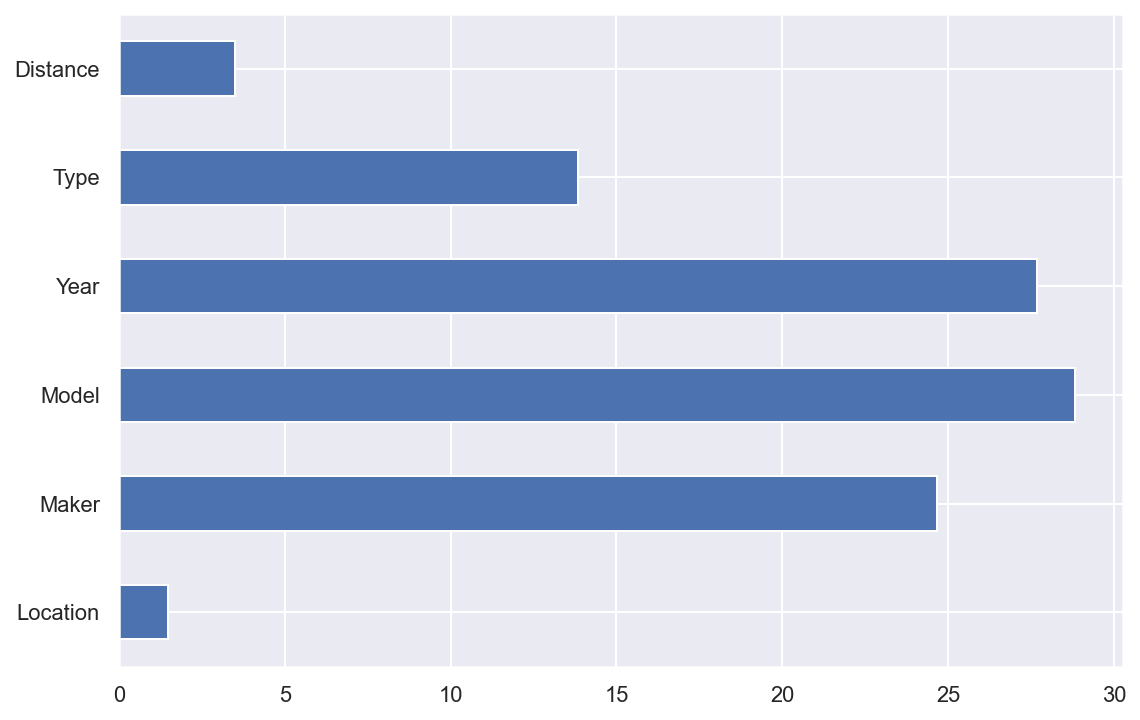

In [32]:
pd.Series(data=cat_reg.feature_importances_, index=cat_reg.feature_names_).plot(kind="barh")

In [34]:
#pd.DataFrame({"VehicleID":test_id.values, "Amount (Million Naira)":predictions}).to_csv(r"C:\Users\HP\Downloads\SUBMISSION.csv", index=False)